In [8]:
import sys
sys.path.append("../")

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Import the OnlineConstrLS class from the previous implementation
# Assuming it's in a file named online_constrained_ls.py
from utils.OnlineCLS import OnlineConstrLS, FrankWolfeOnlineConstrLS


def generate_data(n_samples, n_features, noise=0.1):
    """Generate random data for testing."""
    X = np.random.rand(n_samples, n_features)
    true_weights = np.random.rand(n_features)
    true_weights /= np.sum(true_weights)  # Normalize to sum to 1
    y = np.dot(X, true_weights) + np.random.normal(0, noise, n_samples)
    return X, y, true_weights

def run_monte_carlo(n_trials, n_samples, n_features, noise=0.1):
    """Run Monte Carlo simulation."""
    ocls_mses = []
    ls_mses = []
    weight_errors_ocls = []
    weight_errors_ls = []

    for _ in range(n_trials):
        X, y, true_weights = generate_data(n_samples, n_features, noise)

        # Split data into train and test
        train_size = int(0.8 * n_samples)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # Train and evaluate OnlineConstrLS
        ocls = OnlineConstrLS(unit_interval=True, learning_rate=0.01)
        ocls.fit(X_train, y_train)
        ocls_pred = ocls.predict(X_test)
        ocls_mse = mean_squared_error(y_test, ocls_pred)
        ocls_mses.append(ocls_mse)
        weight_errors_ocls.append(np.mean(np.abs(ocls.coef_ - true_weights)))

        # Train and evaluate standard Least Squares
        ls = LinearRegression()
        ls.fit(X_train, y_train)
        ls_pred = ls.predict(X_test)
        ls_mse = mean_squared_error(y_test, ls_pred)
        ls_mses.append(ls_mse)
        weight_errors_ls.append(np.mean(np.abs(ls.coef_ - true_weights)))

    return ocls_mses, ls_mses, weight_errors_ocls, weight_errors_ls

def plot_results(ocls_mses, ls_mses, weight_errors_ocls, weight_errors_ls):
    """Plot the results of the Monte Carlo simulation."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.boxplot([ocls_mses, ls_mses], labels=['OnlineConstrLS', 'LinearRegression'])
    ax1.set_ylabel('Mean Squared Error')
    ax1.set_title('MSE Comparison')

    ax2.boxplot([weight_errors_ocls, weight_errors_ls], labels=['OnlineConstrLS', 'LinearRegression'])
    ax2.set_ylabel('Mean Absolute Weight Error')
    ax2.set_title('Weight Error Comparison')

    plt.tight_layout()
    plt.show()

/var/folders/4t/vp1c7w5j6v77z1ks_506mr4r0000gn/T/ipykernel_73877/810434465.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([ocls_mses, ls_mses], labels=['OnlineConstrLS', 'LinearRegression'])
/var/folders/4t/vp1c7w5j6v77z1ks_506mr4r0000gn/T/ipykernel_73877/810434465.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([weight_errors_ocls, weight_errors_ls], labels=['OnlineConstrLS', 'LinearRegression'])


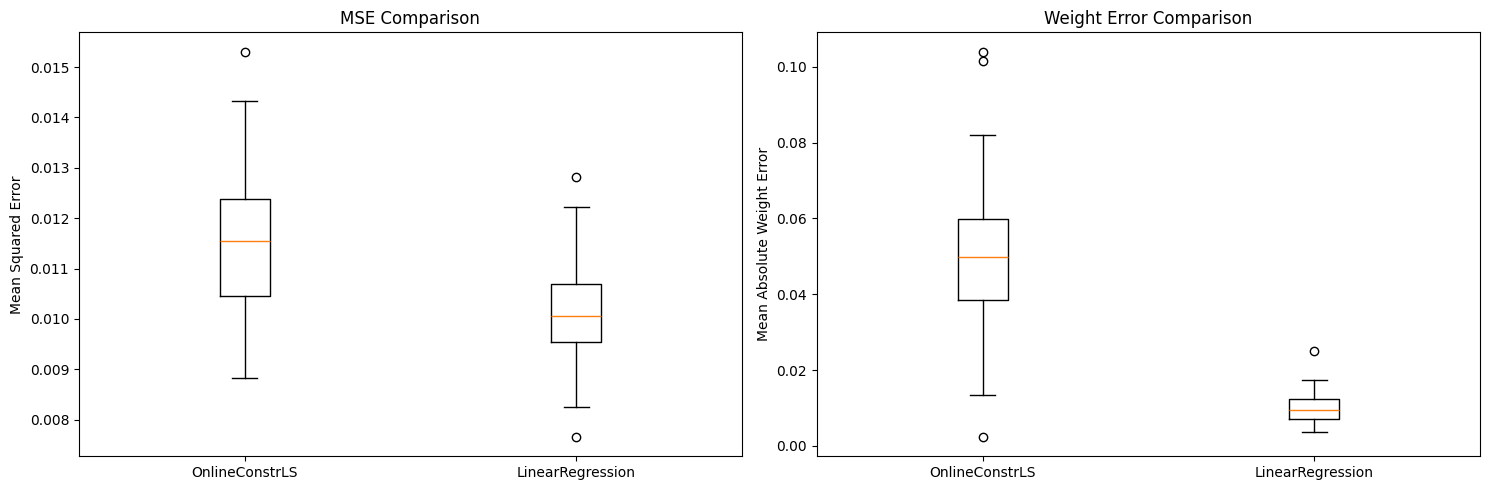

OnlineConstrLS - Mean MSE: 0.01154821957909605
LinearRegression - Mean MSE: 0.010141673988782605
OnlineConstrLS - Mean Weight Error: 0.04968274523770783
LinearRegression - Mean Weight Error: 0.009777513172322373


In [5]:
# Run the simulation
n_trials = 100
n_samples = 1000
n_features = 5
noise = 0.1

ocls_mses, ls_mses, weight_errors_ocls, weight_errors_ls = run_monte_carlo(n_trials, n_samples, n_features, noise)

# Plot the results
plot_results(ocls_mses, ls_mses, weight_errors_ocls, weight_errors_ls)

# Print summary statistics
print("OnlineConstrLS - Mean MSE:", np.mean(ocls_mses))
print("LinearRegression - Mean MSE:", np.mean(ls_mses))
print("OnlineConstrLS - Mean Weight Error:", np.mean(weight_errors_ocls))
print("LinearRegression - Mean Weight Error:", np.mean(weight_errors_ls))

In [15]:
def generate_drifting_weights(n_samples, n_features, drift_speed=0.01):
    """Generate weights that drift over time."""
    weights = np.zeros((n_samples, n_features))
    current_weights = np.random.rand(n_features)
    current_weights /= np.sum(current_weights)  # Normalize to sum to 1

    for i in range(n_samples):
        weights[i] = current_weights
        # Add small random changes
        changes = np.random.normal(0, drift_speed, n_features)
        current_weights += changes
        # Ensure non-negativity
        current_weights = np.maximum(current_weights, 0)
        # Re-normalize to sum to 1
        current_weights /= np.sum(current_weights)

    return weights

def generate_data(n_samples, n_features, noise=0.1, drift_speed=0.01):
    """Generate random data with drifting weights for testing."""
    X = np.random.rand(n_samples, n_features)
    true_weights = generate_drifting_weights(n_samples, n_features, drift_speed)
    y = np.sum(X * true_weights, axis=1) + np.random.normal(0, noise, n_samples)
    return X, y, true_weights

def run_simulation(n_samples, n_features, noise=0.1, drift_speed=0.01):
    """Run simulation with drifting weights."""
    X, y, true_weights = generate_data(n_samples, n_features, noise, drift_speed)

    ocls = OnlineConstrLS(unit_interval=False, learning_rate=0.1)
    ocls_weights = np.zeros((n_samples, n_features))
    ocls_mses = np.zeros(n_samples)
    ocls_abs_weight_diff = np.zeros(n_samples)

    for i in range(n_samples):
        x_t, y_t = X[i:i+1], y[i:i+1]
        ocls.partial_fit(x_t, y_t)
        ocls_weights[i] = ocls.coef_
        ocls_mses[i] = mean_squared_error(y[:i+1], ocls.predict(X[:i+1]))
        ocls_abs_weight_diff[i] = np.mean(np.abs(ocls_weights[i] - true_weights[i])) 

    return true_weights, ocls_weights, ocls_mses, ocls_abs_weight_diff

def plot_results(true_weights, ocls_weights, ocls_mses):
    """Plot the results of the simulation with separate subplots for each coefficient."""
    n_samples, n_features = true_weights.shape

    # Calculate the number of rows needed for the subplots
    n_rows = n_features + 2  # One row for each feature plus one for MSE and one for the ABS weight difference
    fig, axes = plt.subplots(n_rows, 1, figsize=(12, 4 * n_rows), sharex=True)

    # Plot weights for each feature
    for i in range(n_features):
        ax = axes[i]
        ax.plot(true_weights[:, i], label='True Weight', color='blue')
        ax.plot(ocls_weights[:, i], label='Estimated Weight', color='red', linestyle='--')
        ax.set_ylabel(f'Weight {i+1}')
        ax.set_title(f'True vs Estimated Weight for Feature {i+1}')
        ax.legend()

    # Plot MSE over time
    ax_mse = axes[-2]
    ax_mse.plot(ocls_mses, color='green')
    ax_mse.set_xlabel('Time Step')
    ax_mse.set_ylabel('Mean Squared Error')
    ax_mse.set_title('OnlineConstrLS MSE Over Time')
    
    # Plot absolute weight difference over time
    ax_abs_weight_diff = axes[-1]
    ax_abs_weight_diff.plot(ocls_abs_weight_diff, color='purple')
    ax_abs_weight_diff.set_xlabel('Time Step')
    ax_abs_weight_diff.set_ylabel('Mean Absolute Weight Difference')
    ax_abs_weight_diff.set_title('OnlineConstrLS Absolute Weight Difference Over Time')

    plt.tight_layout()
    plt.show()

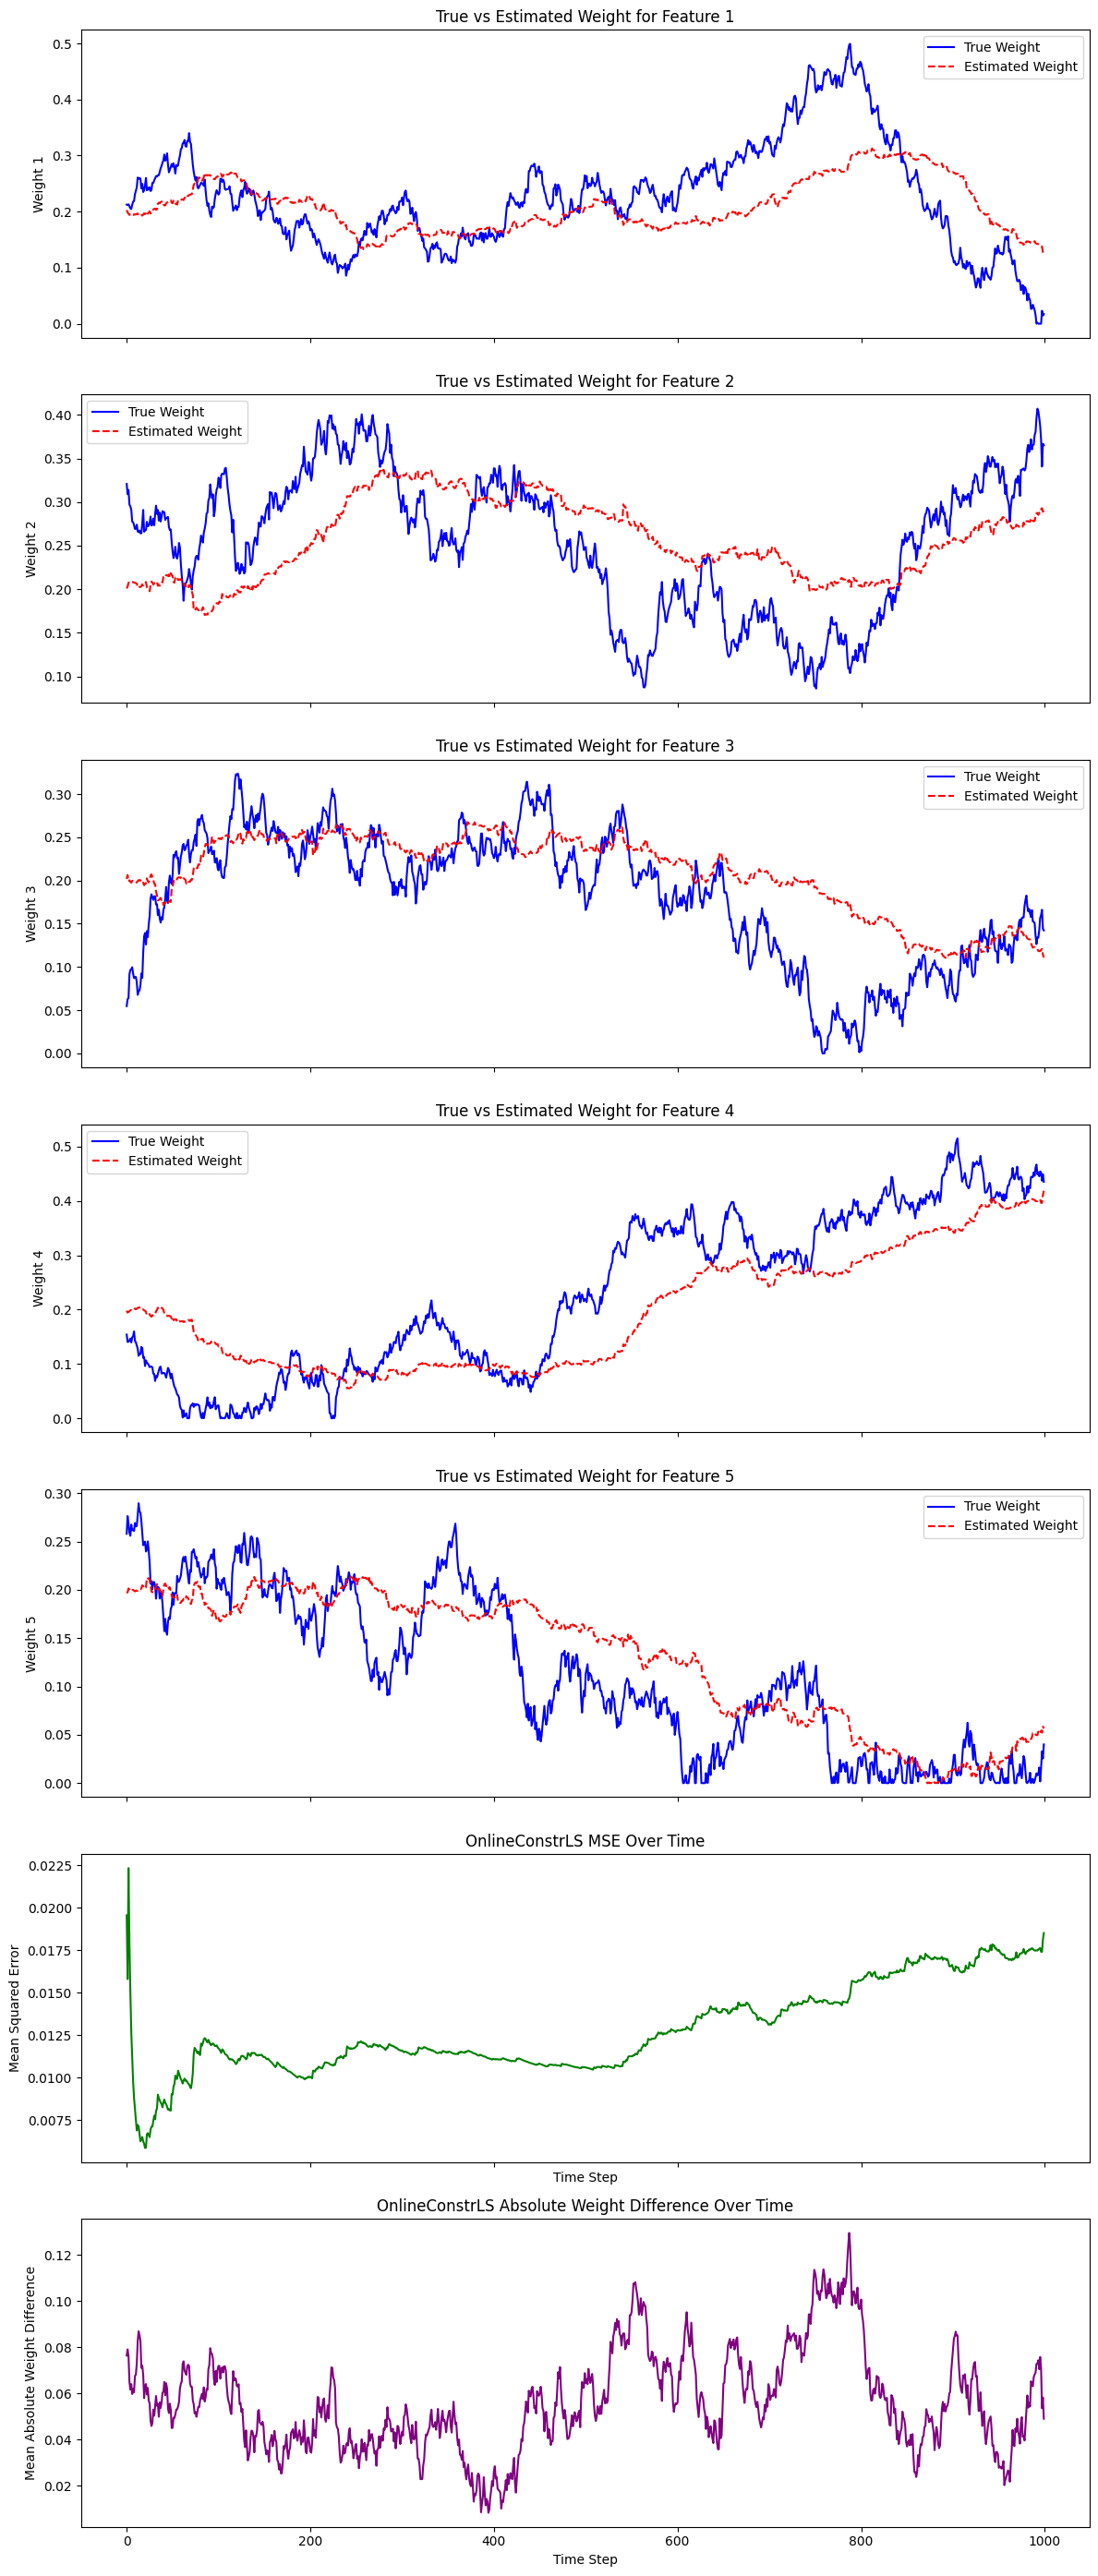

Final MSE: 0.01852185338965038


In [10]:
# Run the simulation
n_samples = 1_000
n_features = 5
noise = 0.1
drift_speed = 0.01

true_weights, ocls_weights, ocls_mses, ocls_abs_weight_diff= run_simulation(n_samples, n_features, noise, drift_speed)

# Plot the results
plot_results(true_weights, ocls_weights, ocls_mses)

# Print final MSE
print("Final MSE:", ocls_mses[-1])

In [26]:
# Check all ocls_weights are positive
print()

False

# Frank Wolfe Method Comparison

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10


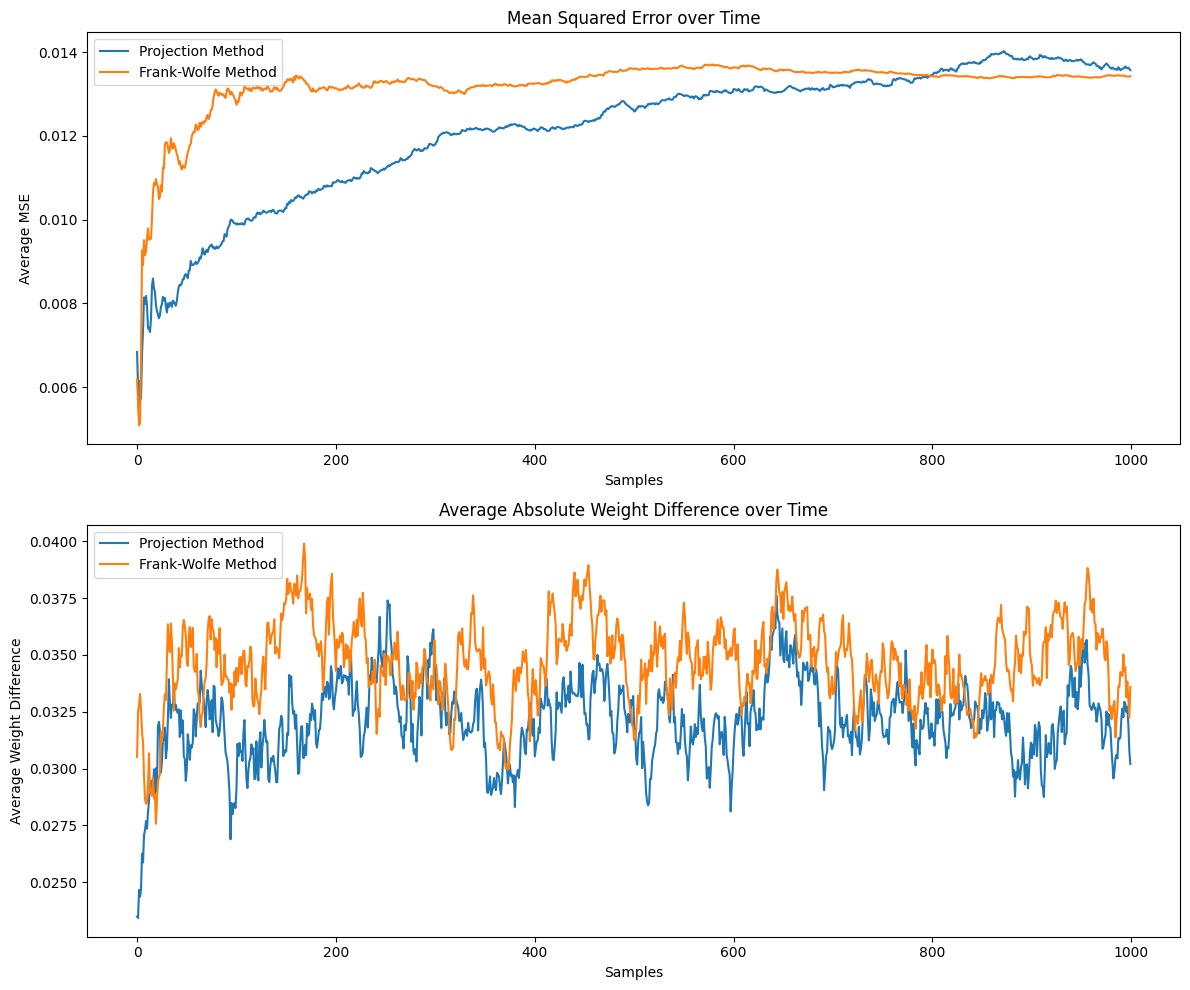

Final Average Results:
Projection Method - MSE: 0.013570, Weight Diff: 0.030202
Frank-Wolfe Method - MSE: 0.013428, Weight Diff: 0.033597


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from time import time

# Assuming OnlineConstrLS and FrankWolfeOnlineConstrLS are defined as before

def generate_drifting_weights(n_samples, n_features, drift_speed=0.01):
    """Generate weights that drift over time."""
    weights = np.zeros((n_samples, n_features))
    current_weights = np.random.rand(n_features)
    current_weights /= np.sum(current_weights)  # Normalize to sum to 1

    for i in range(n_samples):
        weights[i] = current_weights
        # Add small random changes
        changes = np.random.normal(0, drift_speed, n_features)
        current_weights += changes
        # Ensure non-negativity
        current_weights = np.maximum(current_weights, 0)
        # Re-normalize to sum to 1
        current_weights /= np.sum(current_weights)

    return weights

def generate_data(n_samples, n_features, noise=0.1, drift_speed=0.01):
    """Generate random data with drifting weights for testing."""
    X = np.random.rand(n_samples, n_features)
    true_weights = generate_drifting_weights(n_samples, n_features, drift_speed)
    y = np.sum(X * true_weights, axis=1) + np.random.normal(0, noise, n_samples)
    return X, y, true_weights

def run_simulation(model, n_samples, n_features, noise=0.1, drift_speed=0.01):
    """Run simulation with drifting weights."""
    X, y, true_weights = generate_data(n_samples, n_features, noise, drift_speed)

    model_weights = np.zeros((n_samples, n_features))
    model_mses = np.zeros(n_samples)
    model_abs_weight_diff = np.zeros(n_samples)

    for i in range(n_samples):
        x_t, y_t = X[i:i+1], y[i:i+1]
        model.partial_fit(x_t, y_t)
        model_weights[i] = model.coef_
        model_mses[i] = mean_squared_error(y[:i+1], model.predict(X[:i+1]))
        model_abs_weight_diff[i] = np.mean(np.abs(model_weights[i] - true_weights[i]))

    return true_weights, model_weights, model_mses, model_abs_weight_diff

def monte_carlo_simulation(n_runs, n_samples, n_features, noise=0.1, drift_speed=0.01):
    """Run Monte Carlo simulation."""
    ocls_mses = np.zeros((n_runs, n_samples))
    ocls_weight_diffs = np.zeros((n_runs, n_samples))
    fw_mses = np.zeros((n_runs, n_samples))
    fw_weight_diffs = np.zeros((n_runs, n_samples))

    for run in range(n_runs):
        print(f"Run {run + 1}/{n_runs}")
        
        ocls = OnlineConstrLS(unit_interval=False, learning_rate=0.1)
        _, _, ocls_mses[run], ocls_weight_diffs[run] = run_simulation(ocls, n_samples, n_features, noise, drift_speed)
        
        fw = FrankWolfeOnlineConstrLS(learning_rate=0.1)
        _, _, fw_mses[run], fw_weight_diffs[run] = run_simulation(fw, n_samples, n_features, noise, drift_speed)

    return ocls_mses, ocls_weight_diffs, fw_mses, fw_weight_diffs

# Run Monte Carlo simulation
n_runs = 10
n_samples = 1000
n_features = 20
noise = 0.1
drift_speed = 0.01

ocls_mses, ocls_weight_diffs, fw_mses, fw_weight_diffs = monte_carlo_simulation(
    n_runs, n_samples, n_features, noise, drift_speed
)

# Compute average results
avg_ocls_mse = np.mean(ocls_mses, axis=0)
avg_ocls_weight_diff = np.mean(ocls_weight_diffs, axis=0)
avg_fw_mse = np.mean(fw_mses, axis=0)
avg_fw_weight_diff = np.mean(fw_weight_diffs, axis=0)

# Plot results
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(avg_ocls_mse, label='Projection Method')
plt.plot(avg_fw_mse, label='Frank-Wolfe Method')
plt.xlabel('Samples')
plt.ylabel('Average MSE')
plt.title('Mean Squared Error over Time')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(avg_ocls_weight_diff, label='Projection Method')
plt.plot(avg_fw_weight_diff, label='Frank-Wolfe Method')
plt.xlabel('Samples')
plt.ylabel('Average Weight Difference')
plt.title('Average Absolute Weight Difference over Time')
plt.legend()

plt.tight_layout()
plt.show()

# Print final average results
print("Final Average Results:")
print(f"Projection Method - MSE: {avg_ocls_mse[-1]:.6f}, Weight Diff: {avg_ocls_weight_diff[-1]:.6f}")
print(f"Frank-Wolfe Method - MSE: {avg_fw_mse[-1]:.6f}, Weight Diff: {avg_fw_weight_diff[-1]:.6f}")

# Does it converge if stationary

In [43]:
def generate_drifting_weights(n_samples, n_features, drift_speed=0.01):
    """Generate weights that drift over time."""
    weights = np.zeros((n_samples, n_features))
    current_weights = np.random.rand(n_features)
    current_weights /= np.sum(current_weights)  # Normalize to sum to 1

    for i in range(n_samples):
        weights[i] = current_weights
        # Add small random changes
        changes = np.random.normal(0, drift_speed, n_features)
        current_weights += changes
        # Ensure non-negativity
        current_weights = np.maximum(current_weights, 0)
        # Re-normalize to sum to 1
        current_weights /= np.sum(current_weights)

    return weights

def generate_data(n_samples, n_features, noise=0.1):
    """Generate random data for testing."""
    X = np.random.rand(n_samples, n_features)
    true_weights = np.random.rand(n_features)
    true_weights /= np.sum(true_weights)  # Normalize to sum to 1
    y = np.dot(X, true_weights) + np.random.normal(0, noise, n_samples)
    return X, y, true_weights

def run_simulation(n_samples, n_features, noise=0.1, drift_speed=0.01):
    """Run simulation with drifting weights."""
    X, y, true_weights = generate_data(n_samples, n_features, noise)

    ocls = OnlineConstrLS(unit_interval=False, learning_rate=0.01)
    ocls_weights = np.zeros((n_samples, n_features))
    ocls_mses = np.zeros(n_samples)
    ocls_abs_weight_diff = np.zeros(n_samples)

    for i in range(n_samples):
        x_t, y_t = X[i:i+1], y[i:i+1]
        ocls.partial_fit(x_t, y_t)
        ocls_weights[i] = ocls.coef_
        ocls_mses[i] = mean_squared_error(y[:i+1], ocls.predict(X[:i+1]))
        ocls_abs_weight_diff[i] = np.mean(np.abs(ocls_weights[i] - true_weights)) 

    return true_weights, ocls_weights, ocls_mses, ocls_abs_weight_diff

def plot_results(true_weights, ocls_weights, ocls_mses):
    """Plot the results of the simulation with separate subplots for each coefficient."""
    n_features = true_weights.shape[0]
    print(n_features)

    # Calculate the number of rows needed for the subplots
    n_rows = n_features + 2  # One row for each feature plus one for MSE and one for the ABS weight difference
    fig, axes = plt.subplots(n_rows, 1, figsize=(12, 4 * n_rows), sharex=True)

    # Plot weights for each feature
    for i in range(n_features):
        ax = axes[i]
        # ax.plot(true_weights[i], label='True Weight', color='blue')
        # plot line a true weight
        ax.axhline(y=true_weights[i], color="blue")
        ax.plot(ocls_weights[:, i], label='Estimated Weight', color='red', linestyle='--')
        ax.set_ylabel(f'Weight {i+1}')
        ax.set_title(f'True vs Estimated Weight for Feature {i+1}')
        ax.legend()

    # Plot MSE over time
    ax_mse = axes[-2]
    ax_mse.plot(ocls_mses, color='green')
    ax_mse.set_xlabel('Time Step')
    ax_mse.set_ylabel('Mean Squared Error')
    ax_mse.set_title('OnlineConstrLS MSE Over Time')
    
    # Plot absolute weight difference over time
    ax_abs_weight_diff = axes[-1]
    ax_abs_weight_diff.plot(ocls_abs_weight_diff, color='purple')
    ax_abs_weight_diff.set_xlabel('Time Step')
    ax_abs_weight_diff.set_ylabel('Mean Absolute Weight Difference')
    ax_abs_weight_diff.set_title('OnlineConstrLS Absolute Weight Difference Over Time')

    plt.tight_layout()
    plt.show()

5


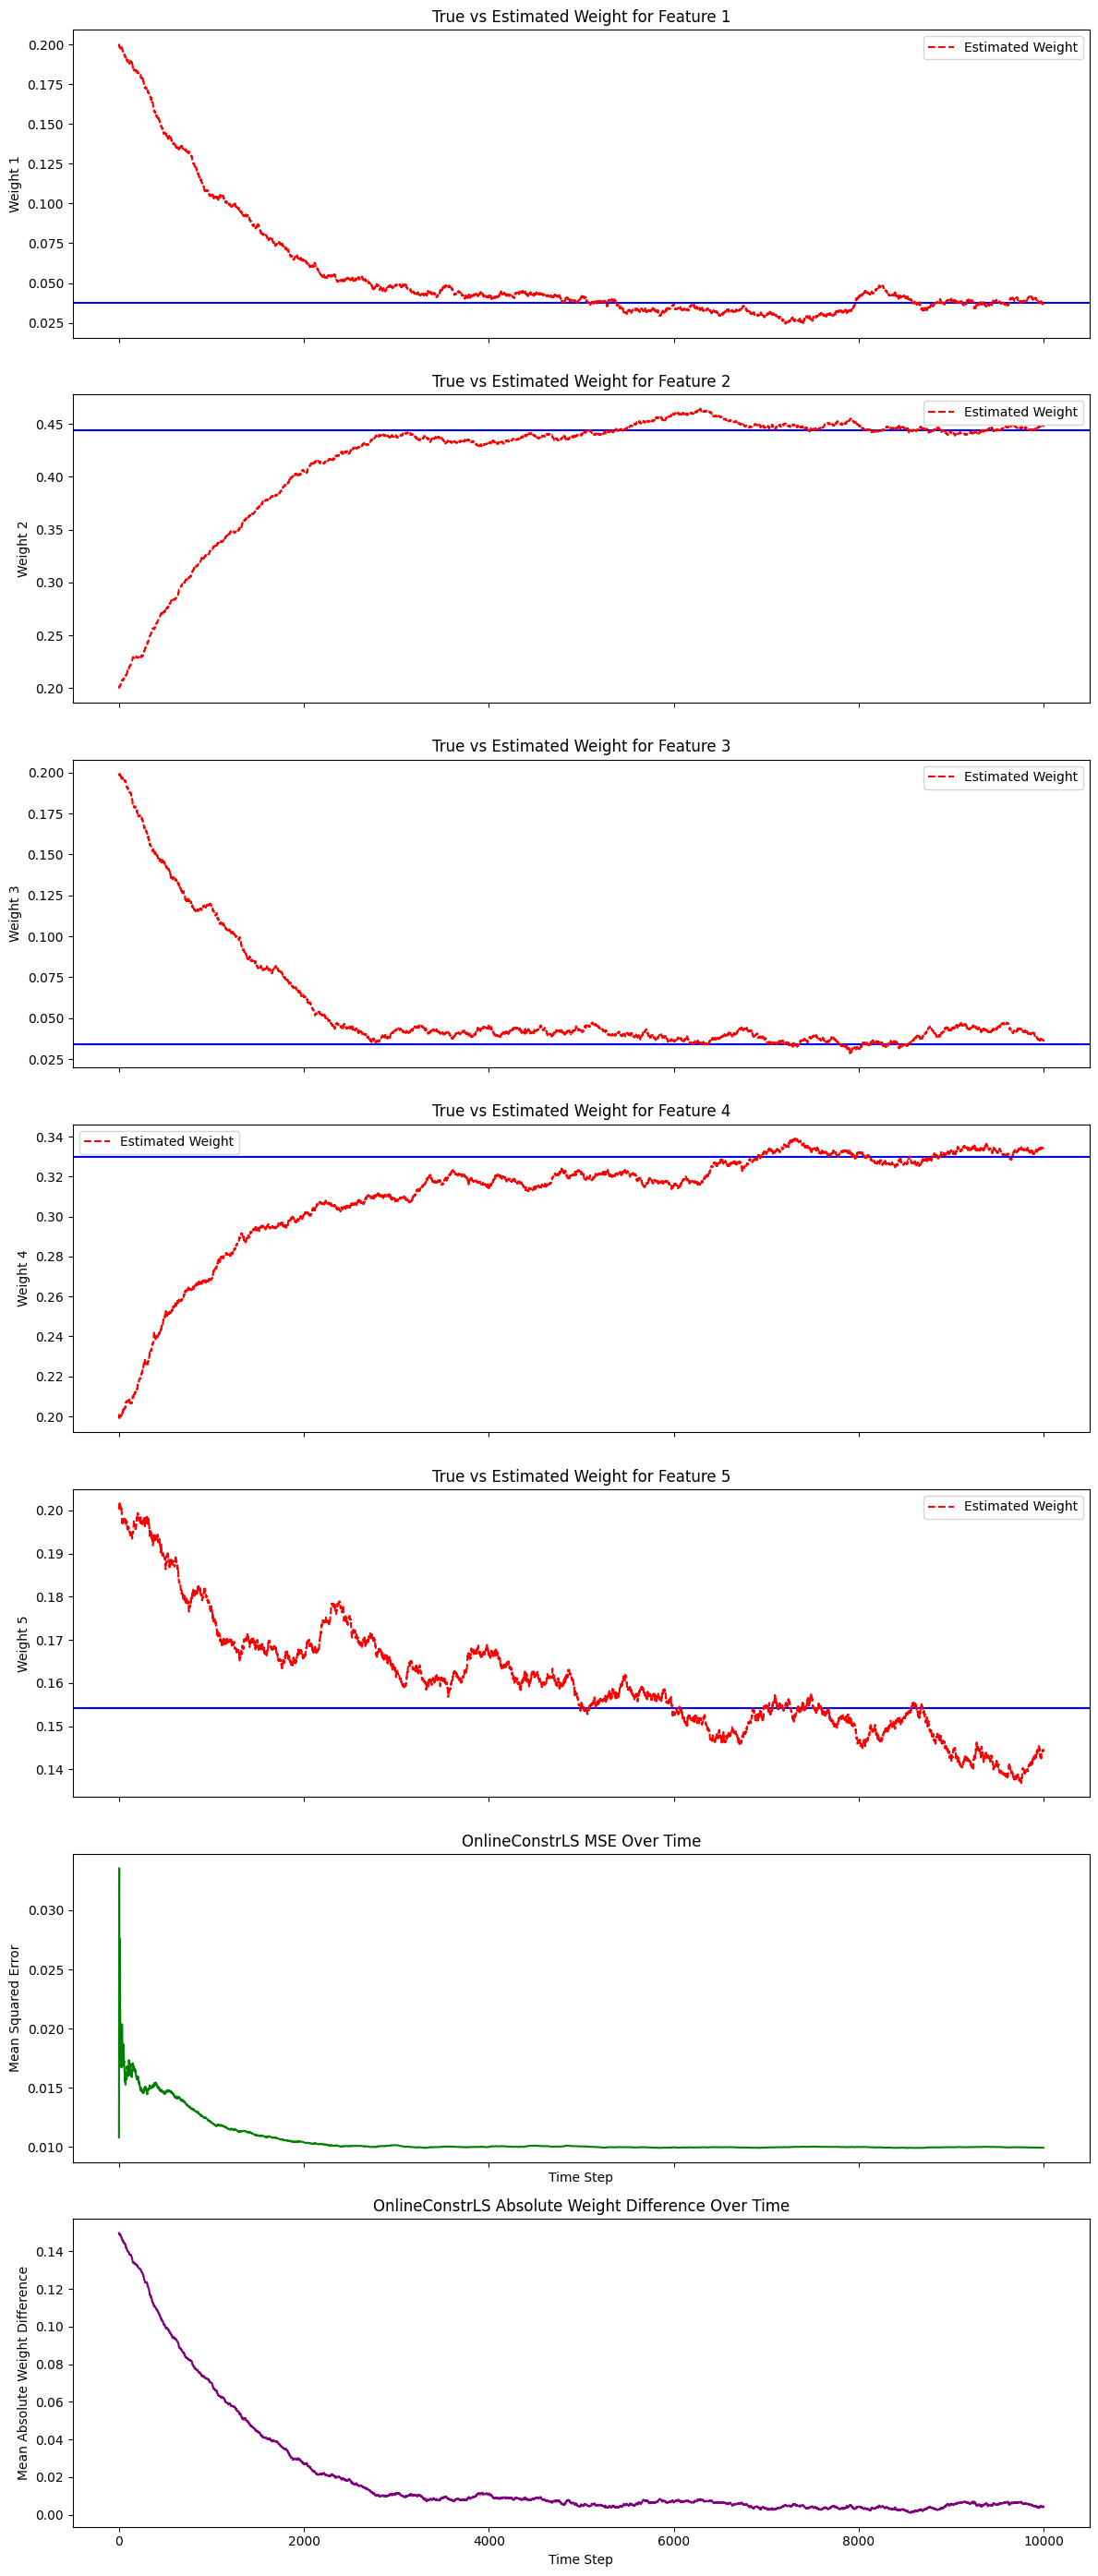

Final MSE: 0.009924833629476697


In [44]:
# Run the simulation
n_samples = 10_000
n_features = 5
noise = 0.1
drift_speed = 0.01

true_weights, ocls_weights, ocls_mses, ocls_abs_weight_diff= run_simulation(n_samples, n_features, noise, drift_speed)

# Plot the results
plot_results(true_weights, ocls_weights, ocls_mses)

# Print final MSE
print("Final MSE:", ocls_mses[-1])